In [39]:
!pip install pillow
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [40]:
import tensorflow as tf

import random
import os
import time
import PIL
import datetime
import numpy as np

from torchvision import transforms
from matplotlib import pyplot as plt
from IPython import display
from PIL import Image, ImageDraw, ImageFilter, ImageOps
from google.colab.patches import cv2_imshow
from google.colab import files
from skimage.metrics import structural_similarity as ssim

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
pathToTraining = "/content/drive/MyDrive/train"
referenceImagePath = "/content/drive/MyDrive/train/referenceImage/"
personImagePath = "/content/drive/MyDrive/train/personImage/"
clothImagePath = "/content/drive/MyDrive/train/warpedClothes/"
clothMask = "/content/drive/MyDrive/train/warp-mask/"

BUFFER_SIZE = 200
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [43]:
def load(image_file):

  cloth = Image.open(clothImagePath+image_file)
  person = Image.open(personImagePath+image_file)
  mask = ImageOps.invert(Image.open(clothMask+image_file))
  merged = np.array(Image.composite(person, cloth, mask), dtype='uint8')

  Rimage = tf.io.read_file(referenceImagePath+image_file)
  Rimage = tf.image.decode_jpeg(Rimage)


  referenceImage = tf.image.resize(tf.cast(Rimage, tf.float32)/255.0, (256,256))
  inputImage = tf.image.resize(tf.cast(merged, tf.float32)/255.0, (256,256))
  Cloth = tf.image.resize(tf.cast(np.array(cloth), tf.float32)/255.0, (256,256))
  Person = tf.image.resize(tf.cast(np.array(person), tf.float32)/255.0, (256,256))
  

  return Cloth, Person, inputImage, referenceImage

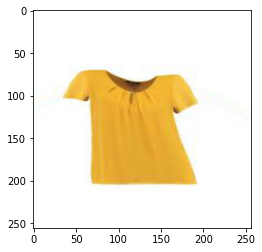

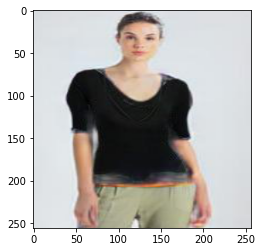

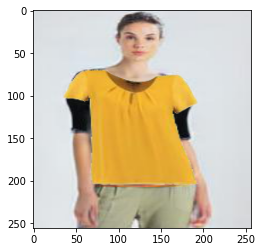

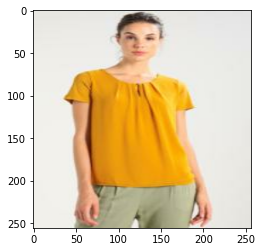

In [44]:
c,p,i,r = load('000048_0.jpg')

plt.figure()
plt.imshow(c)
plt.figure()
plt.imshow(p)
plt.figure()
plt.imshow(i)
plt.figure()
plt.imshow(r)

In [45]:
TrainList = open("/content/drive/MyDrive/train/train.txt", "r")
content = TrainList.read()
TrainingList = content.split()
TrainList.close()
print(list(enumerate(TrainingList)))

[(0, '000404_0.jpg'), (1, '000417_0.jpg'), (2, '000426_0.jpg'), (3, '000437_0.jpg'), (4, '000445_0.jpg'), (5, '000477_0.jpg'), (6, '000501_0.jpg'), (7, '000523_0.jpg'), (8, '000532_0.jpg'), (9, '000542_0.jpg'), (10, '000560_0.jpg'), (11, '000568_0.jpg'), (12, '000576_0.jpg'), (13, '000585_0.jpg'), (14, '000602_0.jpg'), (15, '000610_0.jpg'), (16, '000619_0.jpg'), (17, '000629_0.jpg'), (18, '000639_0.jpg'), (19, '000651_0.jpg'), (20, '000659_0.jpg'), (21, '000668_0.jpg'), (22, '000676_0.jpg'), (23, '000685_0.jpg'), (24, '000706_0.jpg'), (25, '000716_0.jpg'), (26, '000724_0.jpg'), (27, '000742_0.jpg'), (28, '000795_0.jpg'), (29, '000803_0.jpg'), (30, '000812_0.jpg'), (31, '000827_0.jpg'), (32, '000837_0.jpg'), (33, '000846_0.jpg'), (34, '000867_0.jpg'), (35, '000877_0.jpg'), (36, '000898_0.jpg'), (37, '000907_0.jpg'), (38, '000915_0.jpg'), (39, '000934_0.jpg'), (40, '000943_0.jpg'), (41, '000957_0.jpg'), (42, '000968_0.jpg'), (43, '000979_0.jpg'), (44, '000997_0.jpg'), (45, '001009_0.jpg'

In [46]:
TestList = open("/content/drive/MyDrive/train/test.txt", "r")
content = TestList.read()
TestingList = content.split()
TestList.close()
print(list(enumerate(TestingList)))

[(0, '017196_0.jpg'), (1, '017204_0.jpg'), (2, '017235_0.jpg'), (3, '017243_0.jpg'), (4, '017254_0.jpg'), (5, '017264_0.jpg'), (6, '017273_0.jpg'), (7, '017282_0.jpg'), (8, '017290_0.jpg'), (9, '017298_0.jpg'), (10, '017306_0.jpg'), (11, '017315_0.jpg'), (12, '017323_0.jpg'), (13, '017340_0.jpg'), (14, '017348_0.jpg'), (15, '017358_0.jpg'), (16, '017400_0.jpg'), (17, '017410_0.jpg'), (18, '017418_0.jpg'), (19, '017428_0.jpg'), (20, '017438_0.jpg'), (21, '017449_0.jpg'), (22, '017457_0.jpg'), (23, '017466_0.jpg'), (24, '017474_0.jpg'), (25, '017482_0.jpg'), (26, '017496_0.jpg'), (27, '017505_0.jpg'), (28, '017526_0.jpg'), (29, '017536_0.jpg'), (30, '017545_0.jpg'), (31, '017555_0.jpg'), (32, '017563_0.jpg'), (33, '017575_0.jpg'), (34, '017583_0.jpg'), (35, '017592_0.jpg'), (36, '017600_0.jpg'), (37, '017613_0.jpg'), (38, '017630_0.jpg'), (39, '017648_0.jpg'), (40, '017667_0.jpg'), (41, '017688_0.jpg'), (42, '017710_0.jpg'), (43, '017740_0.jpg'), (44, '017750_0.jpg'), (45, '017761_0.jpg'

In [47]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [48]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(r, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [49]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [50]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [51]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

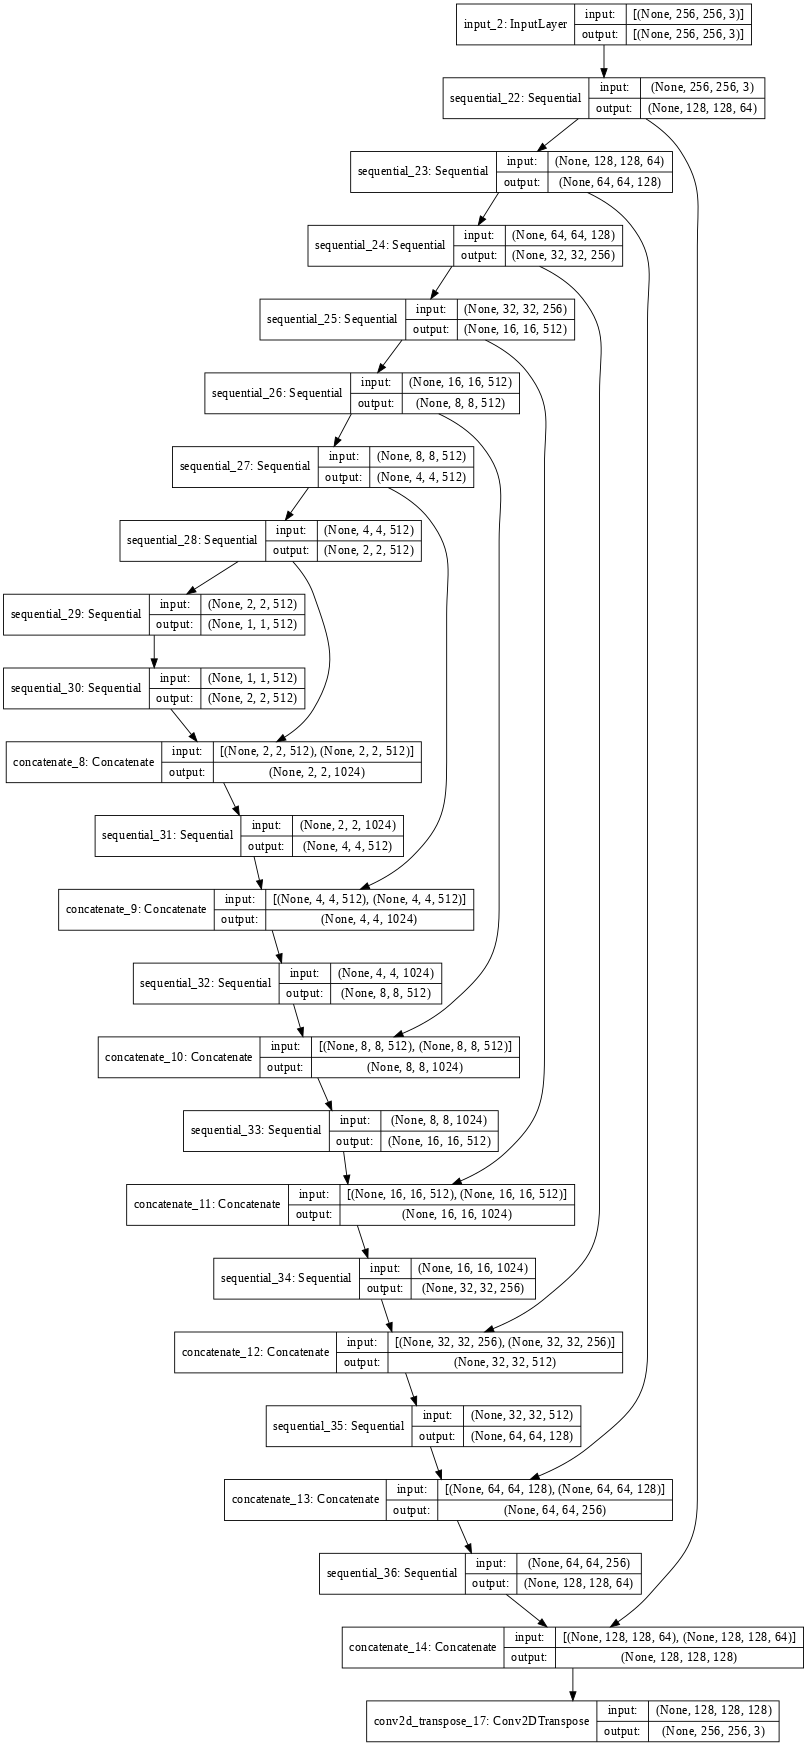

In [52]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


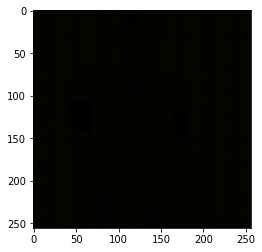

In [53]:
gen_output = generator(i[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
print(gen_output.shape)

In [54]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [55]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

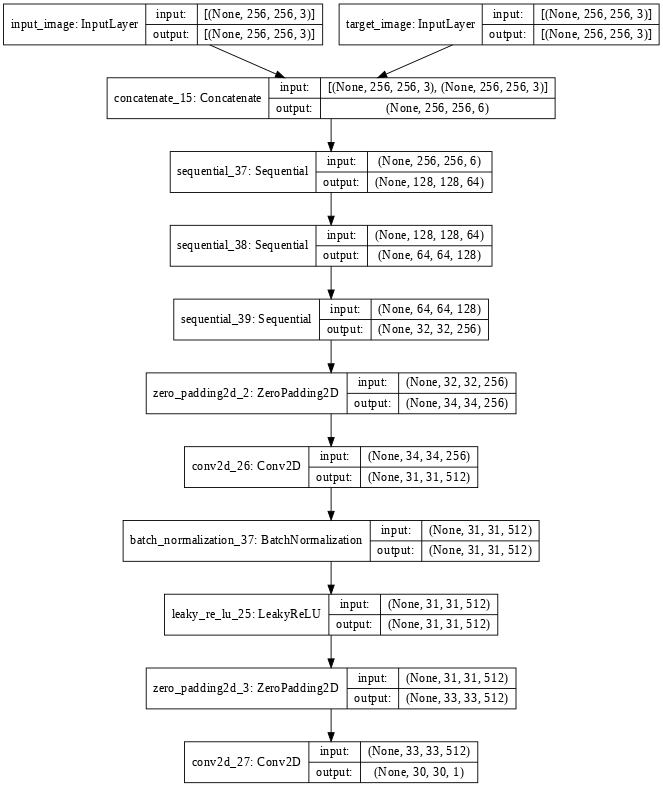

In [56]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

(1, 30, 30, 1)


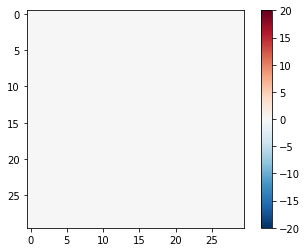

In [57]:
disc_out = discriminator([i[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
print(disc_out.shape)

In [58]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = '/content/drive/MyDrive/train/training_checkpoints4'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [60]:
def generate_test_images(model, imageFile):

  cloth,person,inputImage,tar = load(imageFile)
  prediction = model(inputImage[tf.newaxis, ...], training=True)
  plt.figure(figsize=(15, 15))

  display_list = [cloth, person, prediction[0]]
  title = ['Cloth', 'Person', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

  p=np.squeeze(prediction.numpy(), 0)
  s = ssim(p,tar.numpy(), multichannel = True)
  print("Structural Similarity = ", s)

In [61]:
EPOCHS = 100
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [62]:
@tf.function
def train_step(imageFile):

  c,p,input_image,target = load(imageFile)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image[tf.newaxis, ...], training=True)

    disc_real_output = discriminator([input_image[tf.newaxis, ...], target[tf.newaxis, ...]], training=True)
    disc_generated_output = discriminator([input_image[tf.newaxis, ...], gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [63]:
def fit(TrainList, TestList):
    start = time.time()
    display.clear_output(wait=True)

    generate_test_images(generator, random.choice(TestList))

    # Training step
    for n, (imageFile) in enumerate(TrainList):
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(imageFile)
    print()

    checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for this epoch is {} sec\n'.format(time.time()-start))

In [ ]:
for e in range(EPOCHS):
  print(e)
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  fit(TrainingList, TestingList)

In [65]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
print(tf.train.latest_checkpoint(checkpoint_dir))

/content/drive/MyDrive/train/training_checkpoints4/ckpt-100


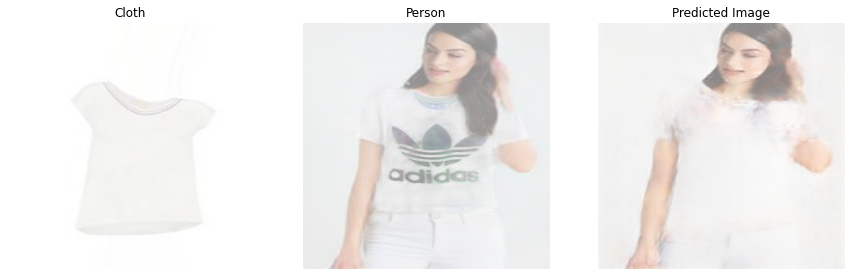

Structural Similarity =  0.8437892867077413


In [163]:
# Run the trained model on a few examples from the test set
generate_test_images(generator,random.choice(TestingList))